# Analysis of 2D cylinder flow at $Re=100$

In [87]:
from os import makedirs, environ
from os.path import join
from collections import defaultdict
import sys
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from scipy.signal import welch
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, environ.get("FLOWTORCH_INSTALL_DIR"))
from flowtorch.data import FOAMDataloader
from flowtorch.analysis import SVD
from simutils import load_force_coeffs, compute_friction_velocity

plt.rcParams["figure.dpi"] = 160
plt.rcParams["text.usetex"] = True
source = environ.get("FLOW_DATA_DIR")
output = join("output", "cylinder_2D_Re100")
makedirs(output, exist_ok=True)

In [2]:
L_REF = 0.1 # cylinder diameter in m
U_REF = 1.0  # maximum inlet velocity in m/s
NU = 1.0e-3  # kinematic viscosity in m^2/s
print(f"Re ={L_REF * U_REF / NU: 1.1f}")

Re = 100.0


In [3]:
case_folders = (
    join(source, "cylinder2D", "cylinder_2D_Re100_m0"),
    join(source, "cylinder2D", "cylinder_2D_Re100_m1"),
    join(source, "cylinder2D", "cylinder_2D_Re100_m2")
)
tmp = join("postProcessing", "samples")
sample_paths = tuple([join(case, tmp) for case in case_folders])

## Force coefficients

In [4]:
coeffs = [load_force_coeffs(path) for path in case_folders]

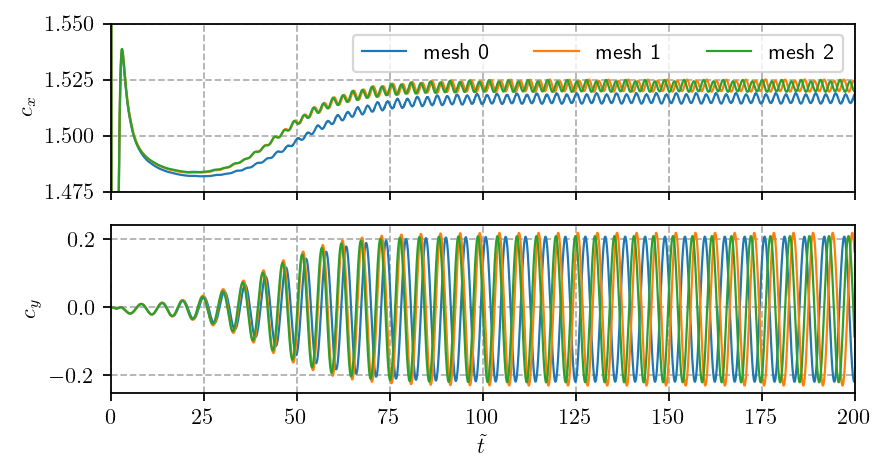

In [5]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 3), sharex=True)

for i, df in enumerate(coeffs):
    t_norm = df.t.values * U_REF / L_REF
    ax1.plot(t_norm, df.cx, lw=1, c=f"C{i}", label=f"mesh {i}")
    ax2.plot(t_norm, df.cy, lw=1, c=f"C{i}")

ax1.set_xlim(0, t_norm[-1])
ax1.set_ylim(1.475, 1.55)
ax1.set_ylabel(r"$c_x$")
ax1.legend(ncol=len(coeffs))
ax1.grid(ls="--")
ax2.set_xlabel(r"$\tilde{t}$")
ax2.set_ylabel(r"$c_y$")
ax2.grid(ls="--")
plt.savefig(join(output, "force_coeffs.png"), dpi=320, bbox_inches="tight")

In [6]:
window = df.t >= 10
cx_mean = np.asarray([df.cx[window].mean() for df in coeffs])
cx_std = np.asarray([df.cx[window].std() for df in coeffs])
cy_std = np.asarray([df.cy[window].std() for df in coeffs])

In [7]:
print(cx_mean, (cx_mean-cx_mean[-1])/cx_mean[-1]*100)
print(cx_std, (cx_std-cx_std[-1])/cx_std[-1]*100)
print(cy_std, (cy_std-cy_std[-1])/cy_std[-1]*100)

[1.51645128 1.52220082 1.52203308] [-0.36673301  0.01102121  0.        ]
[0.00148306 0.00178561 0.00174175] [-14.85253385   2.51837141   0.        ]
[0.15163491 0.15907683 0.15221977] [-0.38421859  4.50471283  0.        ]


In [8]:
f_cx_max, f_cy_max = np.zeros(3), np.zeros(3)
a_cx_max, a_cy_max = np.zeros(3), np.zeros(3)
for i, df in enumerate(coeffs):
    fs = 1.0 / (df.t[1] - df.t[0])
    cx = df.cx[window].values
    cy = df.cy[window].values
    f, a = welch(cx, fs=fs, window="boxcar", nperseg=len(cx), nfft=2*len(cx))
    f_cx_max[i] = f[np.argmax(a)]
    a_cx_max[i] = np.max(a)
    f, a = welch(cy, fs=fs, window="boxcar", nperseg=len(cy), nfft=2*len(cy))
    f_cy_max[i] = f[np.argmax(a)]
    a_cy_max[i] = np.max(a)

In [9]:
f_cx_max, f_cx_max * L_REF / U_REF, (f_cx_max - f_cx_max[-1]) / f_cx_max[-1] * 100

(array([3.74925015, 3.79924015, 3.79924015]),
 array([0.37492501, 0.37992402, 0.37992402]),
 array([-1.31578947,  0.        ,  0.        ]))

In [10]:
a_cx_max, (a_cx_max - a_cx_max[-1]) / a_cx_max[-1] * 100

(array([2.02424598e-05, 3.11842928e-05, 2.75215149e-05]),
 array([-26.44859887,  13.30878028,   0.        ]))

In [11]:
f_cy_max, f_cy_max * L_REF / U_REF, (f_cy_max - f_cy_max[-1]) / f_cy_max[-1] * 100

(array([1.84963007, 1.89962008, 1.89962008]),
 array([0.18496301, 0.18996201, 0.18996201]),
 array([-2.63157895,  0.        ,  0.        ]))

In [12]:
a_cy_max, (a_cy_max - a_cy_max[-1]) / a_cy_max[-1] * 100

(array([0.20673385, 0.25255987, 0.22699879]),
 array([-8.92733255, 11.26044744,  0.        ]))

## Velocity gradient and friction velocity

In [15]:
u_tau_cylinder, u_tau_top = [], []
for path in sample_paths:
    u_tau_cylinder.append(compute_friction_velocity(path, "gradU_cylinder.raw", 10, NU))
    u_tau_top.append(compute_friction_velocity(path, "gradU_top.raw", 10, NU))

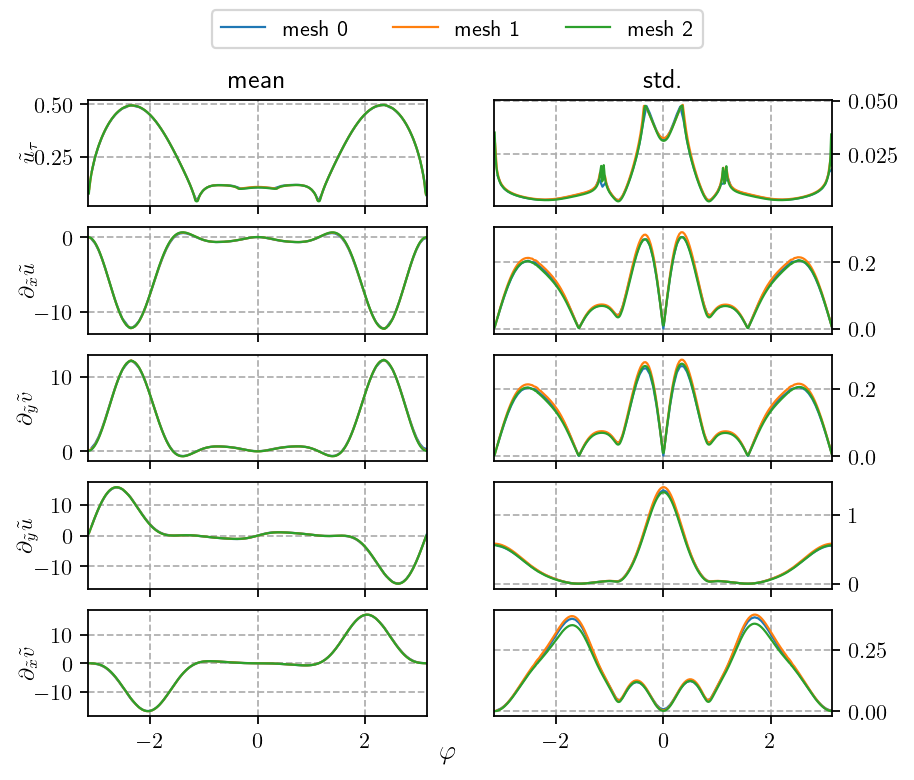

In [43]:
fig, axarr = plt.subplots(5, 2, figsize=(6, 5), sharex=True)

slope_norm = U_REF / L_REF
for i, (x, y, _, _, u_tau, grad_u) in enumerate(u_tau_cylinder):
    phi = np.arctan2(y-0.2, x-0.2)
    phi_sort = np.argsort(phi)
    u_tau_mean = np.mean(np.vstack(u_tau), axis=0)
    u_tau_std = np.std(np.vstack(u_tau), axis=0)
    axarr[0, 0].plot(phi[phi_sort], u_tau_mean[phi_sort]/U_REF, c=f"C{i}", lw=1, label=f"mesh {i}")
    axarr[0, 1].plot(phi[phi_sort], u_tau_std[phi_sort]/U_REF, c=f"C{i}", lw=1)
    grad_u_mean = np.mean(np.asarray(grad_u), axis=0)
    grad_u_std = np.std(np.asarray(grad_u), axis=0)
    axarr[1, 0].plot(phi[phi_sort], grad_u_mean[phi_sort, 0, 0]/slope_norm, c=f"C{i}", lw=1)
    axarr[1, 1].plot(phi[phi_sort], grad_u_std[phi_sort, 0, 0]/slope_norm, c=f"C{i}", lw=1)
    axarr[2, 0].plot(phi[phi_sort], grad_u_mean[phi_sort, 1, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[2, 1].plot(phi[phi_sort], grad_u_std[phi_sort, 1, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[3, 0].plot(phi[phi_sort], grad_u_mean[phi_sort, 0, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[3, 1].plot(phi[phi_sort], grad_u_std[phi_sort, 0, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[4, 0].plot(phi[phi_sort], grad_u_mean[phi_sort, 1, 0]/slope_norm, c=f"C{i}", lw=1)
    axarr[4, 1].plot(phi[phi_sort], grad_u_std[phi_sort, 1, 0]/slope_norm, c=f"C{i}", lw=1)
handles, labels = axarr[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(u_tau_cylinder))
fig.supxlabel(r"$\varphi$", y=0.05)
for ax in axarr.flatten():
    ax.set_xlim(-np.pi, np.pi)
    ax.grid(ls="--")
    ax.yaxis.set_label_coords(-0.15, 0.5)
for ax in axarr[:, 1].flatten():
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
axarr[0, 0].set_ylabel(r"$\tilde{u}_\tau$")
axarr[1, 0].set_ylabel(r"$\partial_{\tilde{x}} \tilde{u}$")
axarr[2, 0].set_ylabel(r"$\partial_{\tilde{y}} \tilde{v}$")
axarr[3, 0].set_ylabel(r"$\partial_{\tilde{y}} \tilde{u}$")
axarr[4, 0].set_ylabel(r"$\partial_{\tilde{x}} \tilde{v}$")
axarr[0, 0].set_title("mean")
axarr[0, 1].set_title("std.")

plt.savefig(join(output, "u_tau_cylinder.png"), dpi=320, bbox_inches="tight")

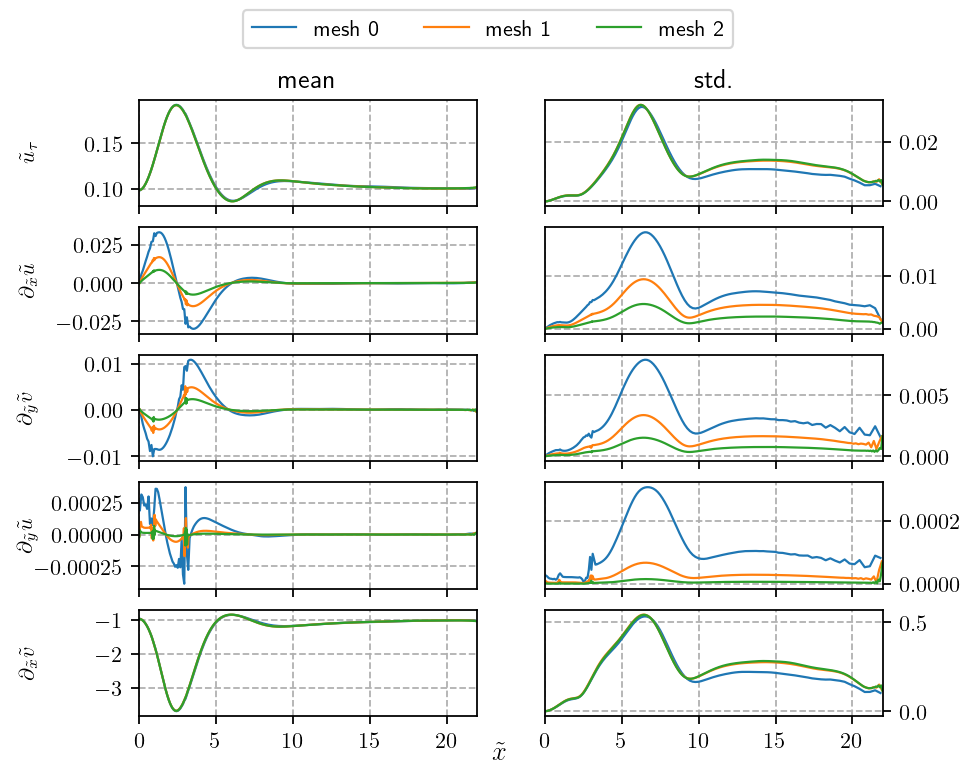

In [48]:
fig, axarr = plt.subplots(5, 2, figsize=(6, 5), sharex=True)

slope_norm = U_REF / L_REF
for i, (x, y, _, _, u_tau, grad_u) in enumerate(u_tau_top):
    x_sort = np.argsort(x)
    u_tau_mean = np.mean(np.vstack(u_tau), axis=0)
    u_tau_std = np.std(np.vstack(u_tau), axis=0)
    axarr[0, 0].plot(x[x_sort]/L_REF, u_tau_mean[x_sort]/U_REF, c=f"C{i}", lw=1, label=f"mesh {i}")
    axarr[0, 1].plot(x[x_sort]/L_REF, u_tau_std[x_sort]/U_REF, c=f"C{i}", lw=1)
    grad_u_mean = np.mean(np.asarray(grad_u), axis=0)
    grad_u_std = np.std(np.asarray(grad_u), axis=0)
    axarr[1, 0].plot(x[x_sort]/L_REF, grad_u_mean[x_sort, 0, 0]/slope_norm, c=f"C{i}", lw=1)
    axarr[1, 1].plot(x[x_sort]/L_REF, grad_u_std[x_sort, 0, 0]/slope_norm, c=f"C{i}", lw=1)
    axarr[2, 0].plot(x[x_sort]/L_REF, grad_u_mean[x_sort, 1, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[2, 1].plot(x[x_sort]/L_REF, grad_u_std[x_sort, 1, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[3, 0].plot(x[x_sort]/L_REF, grad_u_mean[x_sort, 0, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[3, 1].plot(x[x_sort]/L_REF, grad_u_std[x_sort, 0, 1]/slope_norm, c=f"C{i}", lw=1)
    axarr[4, 0].plot(x[x_sort]/L_REF, grad_u_mean[x_sort, 1, 0]/slope_norm, c=f"C{i}", lw=1)
    axarr[4, 1].plot(x[x_sort]/L_REF, grad_u_std[x_sort, 1, 0]/slope_norm, c=f"C{i}", lw=1)
handles, labels = axarr[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(u_tau_top))
fig.supxlabel(r"$\tilde{x}$", y=0.05)
for ax in axarr.flatten():
    ax.set_xlim(0, 22)
    ax.grid(ls="--")
    ax.yaxis.set_label_coords(-0.3, 0.5)
for ax in axarr[:, 1].flatten():
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
axarr[0, 0].set_ylabel(r"$\tilde{u}_\tau$")
axarr[1, 0].set_ylabel(r"$\partial_{\tilde{x}} \tilde{u}$")
axarr[2, 0].set_ylabel(r"$\partial_{\tilde{y}} \tilde{v}$")
axarr[3, 0].set_ylabel(r"$\partial_{\tilde{y}} \tilde{u}$")
axarr[4, 0].set_ylabel(r"$\partial_{\tilde{x}} \tilde{v}$")
axarr[0, 0].set_title("mean")
axarr[0, 1].set_title("std.")

plt.savefig(join(output, "u_tau_top.png"), dpi=320, bbox_inches="tight")

## Singular values

In [120]:
def assemble_data_matrix(path, t_start, n_times):
    loader = FOAMDataloader(path, distributed=True, dtype=pt.float64)
    times = loader.write_times
    times = [t for t in times if float(t) >= t_start]
    times = times[:min(n_times, len(times))]
    vertices = loader.vertices
    weights = loader.weights
    x, y, _ = vertices[:, 0], vertices[:, 1], vertices[:, 2]
    vel = loader.load_snapshot("U", times)
    dm = pt.cat((vel[:, 0], vel[:, 1]), dim=0)
    times = pt.tensor([float(t) for t in times])
    return x, y, times - times[0], weights, dm

In [121]:
dm_means, dm_stds = [], []
steps, n_times = 10, 2500
for case in case_folders:
    _, _, times, w, dm = assemble_data_matrix(case, 10, n_times)
    ws = w.unsqueeze(-1).repeat((2, 1)).sqrt()
    dm_means.append([(dm[:, :n]*ws).mean(dim=1).norm() for n in range(steps, n_times+1, steps)])
    dm_stds.append([(dm[:, :n]*ws).std(dim=1).norm() for n in range(steps, n_times+1, steps)])

Loading precomputed cell centers and volumes from processor0/constant
Loading precomputed cell centers and volumes from processor1/constant
Loading precomputed cell centers and volumes from processor0/constant
Loading precomputed cell centers and volumes from processor1/constant
Loading precomputed cell centers and volumes from processor0/constant
Loading precomputed cell centers and volumes from processor1/constant
Loading precomputed cell centers and volumes from processor2/constant
Loading precomputed cell centers and volumes from processor3/constant


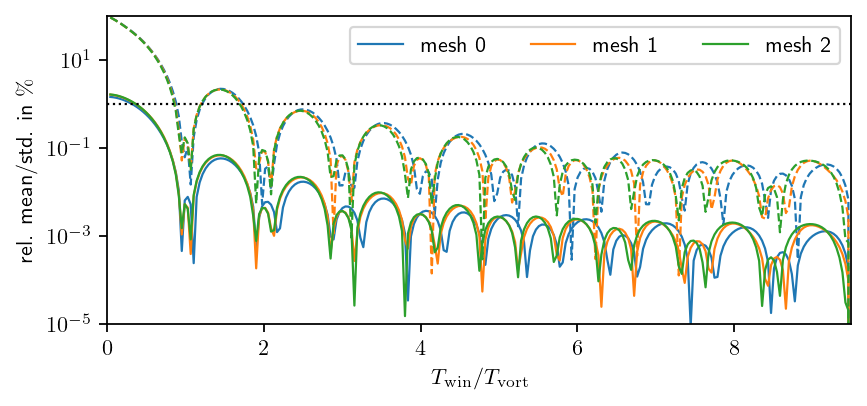

In [122]:
fig, ax = plt.subplots(figsize=(6, 2.5), sharex=True)

periods = np.array(range(steps, n_times+1, steps)) * 2.0e-3 * f_cy_max[-1]
for i, case in enumerate(case_folders):
    mean_rel = (pt.tensor(dm_means[i])-dm_means[i][-1]).abs()/dm_means[i][-1] * 100
    std_rel = (pt.tensor(dm_stds[i])-dm_stds[i][-1]).abs()/dm_stds[i][-1] * 100
    ax.plot(periods, mean_rel, c=f"C{i}", lw=1, label=f"mesh {i}")
    ax.plot(periods, std_rel, c=f"C{i}", ls="--", lw=1)

ax.axhline(1, ls=":", c="k", lw=1)
ax.set_xlabel(r"$T_\mathrm{win}/T_\mathrm{vort}$")
ax.set_ylabel(r"rel. mean/std. in $\%$")
ax.legend(ncol=3)
ax.set_xlim(0, periods[-1])
ax.set_ylim(1e-5, 100)
ax.set_yscale("log")
plt.savefig(join(output, "window_statistics.png"), dpi=320, bbox_inches="tight")

In [124]:
n_svals = 10
n_times = n_svals*30
rec_err = defaultdict(list)
for case in case_folders:
    x, y, times, w, dm = assemble_data_matrix(case, 10, n_times)
    ws = w.unsqueeze(-1).repeat((2, 1)).sqrt()
    dm *= ws
    dm_norm = dm.norm()
    for n in range(n_svals, n_times+1, n_svals):
        svd = SVD(dm[:, :n], rank=n_svals)
        err = (svd.U @ (svd.U.T @ dm) - dm).norm()
        rec_err[case].append((err/dm_norm * 100).item())
    del svd, dm

Loading precomputed cell centers and volumes from processor0/constant
Loading precomputed cell centers and volumes from processor1/constant
Loading precomputed cell centers and volumes from processor0/constant
Loading precomputed cell centers and volumes from processor1/constant
Loading precomputed cell centers and volumes from processor0/constant
Loading precomputed cell centers and volumes from processor1/constant
Loading precomputed cell centers and volumes from processor2/constant
Loading precomputed cell centers and volumes from processor3/constant


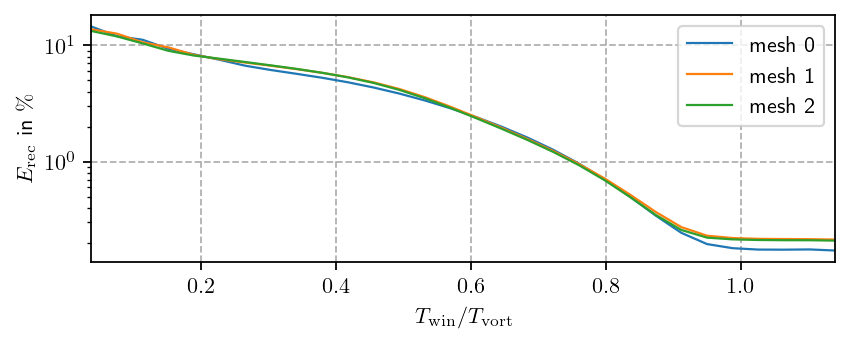

In [125]:
fig, ax = plt.subplots(figsize=(6, 2))

periods = np.array(range(n_svals, n_times+1, n_svals)) * 2.0e-3 * f_cy_max[-1]

for i, case in enumerate(case_folders):
    ax.plot(periods, rec_err[case], lw=1, c=f"C{i}", label=f"mesh {i}")

ax.legend()
ax.set_xlabel(r"$T_\mathrm{win}/T_\mathrm{vort}$")
ax.set_ylabel(r"$E_\mathrm{rec}$ in $\%$")
ax.set_yscale("log")
ax.set_xlim(periods[0], periods[-1])
ax.grid(ls="--")
plt.savefig(join(output, "window_svd_rec_err.png"), dpi=320, bbox_inches="tight")